# Project Description

This notebook is part of a mobile app project, which goal is to help the management of indoor plants with key features, such as watering reminders or diseases detection. 

Four notebooks are associated to the automation part:
1. A notebook to analyse the data for classification,
2. A notebook to analyse the data for detection,
3. A notebook to train and evaluate our image classification model,
4. A notebook to train and evaluate our object detection model.

.................................................................

This notebook is the first. Its goal is to get a better understanding of the classification datasets:
* **PlantDoc Dataset** for object detection, applied to detect and identify diseases. 


From this analysis, we will be able to select the most suitable data to train our models.




---
# 1. PlantDoc

## I) Setup

To download the data, roboflow (the company that deliver the dataset) offers you to choose between several format.

Choose the COCO JSON format and paste the URL they give you below to download the dataset on the Notebook Instance.
* URL to get the dataset: https://public.roboflow.ai/object-detection/plantdoc/1                                                       


### a) Download the dataset

In [103]:
import os
import urllib.request

def download(url):
    filename = "PlantDoc.v1-resize-416x416.coco.zip"
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# Download the zipped dataset
download("<URL-provided-by-roboflow>")

In [105]:
if not os.path.exists("PlantDoc-datasets"):
    # Create folder
    !mkdir "PlantDoc-datasets"
    # Move Zip to a folder
    !mv "PlantDoc.v1-resize-416x416.coco.zip" "PlantDoc-datasets/PlantDoc.v1-resize-416x416.coco.zip"
    # Unzip in the folder
    !unzip -qo "PlantDoc-datasets/PlantDoc.v1-resize-416x416.coco.zip" -d "PlantDoc-datasets/"
    # Delete the zip file
    !rm "PlantDoc-datasets/PlantDoc.v1-resize-416x416.coco.zip"
    # Rename the test folder to validation folder
    !mv "PlantDoc-datasets/test" "PlantDoc-datasets/validation"
else:
    print("Directory already exists.")

In [106]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt   
from plotly.subplots import make_subplots
from scipy.stats import entropy
import tarfile
import requests 
from io import StringIO
from s3fs.core import S3FileSystem

import boto3, re, sys, math, json, os, sagemaker, urllib.request                             


Set up the environment

In [107]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::083737275477:role/service-role/AmazonSageMaker-ExecutionRole-20200728T141705


In [108]:
s3_ressource = boto3.resource('s3')
s3_client = boto3.client('s3')
s3_fs = S3FileSystem(anon=False)
bucket_in = 'diseases-detection-datasets'
prefix = "datasets"
#bucket_in = s3_ressource.Bucket(bucket_inName)

## II) Data preparation | Training

### a) Annotations

The dataset provides 2 json annotations files, one for training and one for validation:
* "PlantDoc-datasets/test/_annotations.json"
* "PlantDoc-datasets/train/_annotations.json"

We will read these files to lead an analysis and then will create one json file per image.

In [150]:
def prepare_data(file, store_folder = None, filtered_list = None):
    data = []
    header = ["FileName", "ImageWidth","ImageHeight","ImageDepth","ClassId","Top","Left","Width", "Height", "ClassId0", "Name"]
   
    with open(file) as f:
        js = json.load(f)    
        images = js['images']
        categories = js['categories']
        annotations = js['annotations']
        for i in images:
            if filtered_list and str(i['file_name']) not in filtered_list:
                continue
            img = []
            jsonFile = i['file_name']
            jsonFile = jsonFile.split('.')[0]+'.json'
        
            line = {}
            line['file'] = i['file_name']
            line['image_size'] = [{
                'width':int(i['width']),
                'height':int(i['height']),
                'depth':3
            }]
            line['annotations'] = []
            line['categories'] = []
            for j in annotations:
                if j['image_id'] == i['id'] and len(j['bbox']) > 0:
                    line['annotations'].append({
                        'class_id':int(j['category_id']),
                        'top':int(j['bbox'][1]),
                        'left':int(j['bbox'][0]),
                        'width':int(j['bbox'][2]),
                        'height':int(j['bbox'][3])
                    })
                    class_name = ''
                    for k in categories:
                        if int(j['category_id']) == k['id']:
                            class_name = str(k['name'])
                    assert class_name is not ''
                    line['categories'].append({
                        'class_id':int(j['category_id']),
                        'name':class_name
                    })
                    line_list = []
                    for l in line.values():
                        if isinstance(l, list):
                            for k in l[0].values():
                                line_list.append(k)
                        else:
                            line_list.append(l)
                    data.append(line_list)
                        
            if store_folder and line['annotations']:
                with open(os.path.join(store_folder, jsonFile),'w') as p:
                    json.dump(line,p)

    return pd.DataFrame(data, columns = header)

In [140]:
from s3fs.core import S3FileSystem
s3_fs = S3FileSystem(anon=False)
# Load Data from the instance or from s3 if stored
try:
    df_train = prepare_data( "PlantDoc-datasets/train/_annotations.coco.json")
    df_validation = prepare_data("PlantDoc-datasets/validation/_annotations.coco.json")
    df_train["LearnTag"] = "Train"
    df_validation["LearnTag"]="Validation"
    df = pd.concat([df_train, df_validation])
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print("Data Load Error:",e)

Success: Data loaded into dataframe.


In [117]:
import os
import json
jsons_train = os.listdir('PlantDoc-datasets/train_annotation')
jsons_validation = os.listdir('PlantDoc-datasets/validation_annotation')

print ('There are {} images have annotation files for training and {} for validation.'.format(len(jsons_train),len(jsons_validation)))

There are 2318 images have annotation files for training and 238 for validation.




---


## III) Data Inspection

We will focus our study to have a better understanding of our dataset to prevent some results of the training of the algorithms. For instance, we will look at:
* The repartition of the classes data within the dataset,
* The repartition of the data between the training and validation sets,
* Number of leaves per images,
* The characteristics of each classes: 
    * Dimension of a plant, 
    * Number of healthy and unhealthy leaves.

### a) Dataset Overview

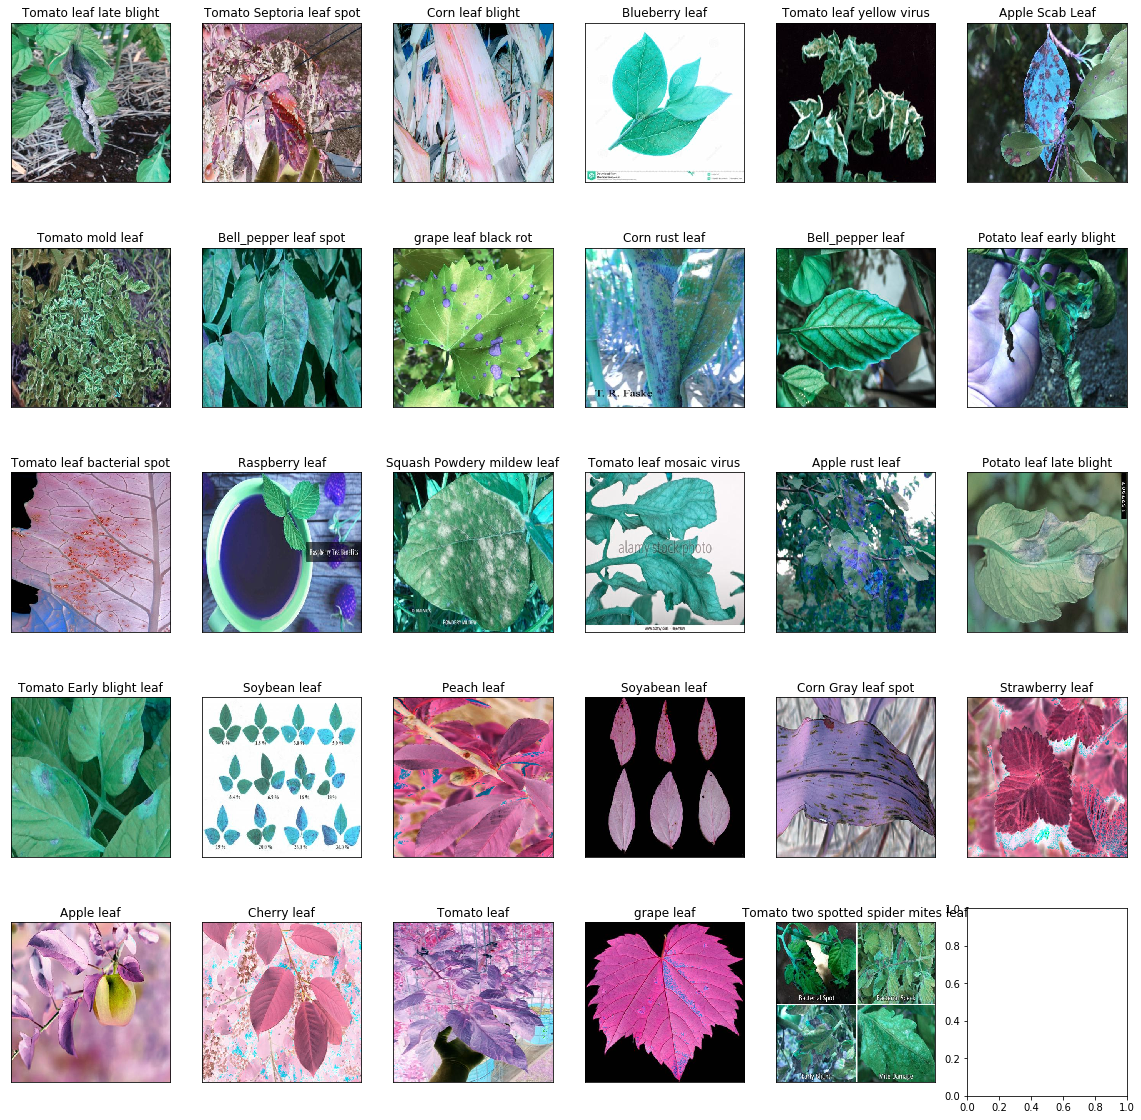

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import io
from PIL import Image

# Function to read images from S3
def read_image_from_s3(bucket_in, key):
    bucket_in = s3_ressource.Bucket(bucket_in)
    img_object = bucket_in.Object(key)
    response = img_object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)

# Display images for different species
def plot(df, rows, cols, bucket = None):
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
    species = df['Name'].unique()
    n = 0
    for i in range(rows):
        for j in range(cols):
            if n < len(df['Name'].unique()):
                file = str(df["FileName"][df["Name"] == species[n]].iloc[0])
                directory = str(df["LearnTag"][df["Name"] == species[n]].iloc[0]).lower()
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].title.set_text(species[n])
                if bucket: 
                    key = "{}/{}/{}".format(prefix, directory , file)
                    ax[i, j].imshow(read_image_from_s3(bucket_or_directory,key ))
                else:
                    path = "./{}/{}".format(directory , file)
                    ax[i, j].imshow(cv2.imread(path))
                n += 1
    
# Displays first n images of class from training set
plot(df, 5, 6)

### b) Pre-Processing

Study of the different plants.

In order to achieve this study, we will add two columns to our dataframe:
* A column with the name of the Plant (and not only the plant and associated disease),
* A column with the disease type (excluding the plant name).

Then we will be able to have a better understanding of the data we are dealing with. 

In [121]:
#First, lower case strings
df["Name"]= df['Name'].apply(lambda x: x.lower())

# Get plant's name for each disease
plants = []
for i in df["Name"].unique():
    #if i.split(" ", 1)[0] not in plants:
    plants.append(i.split(None, 1)[0])

# Get unique plant's name 
plants_unique = list( dict.fromkeys(plants))

# Get Diseases Names
diseases = []
count_diseases  = []
for d in df["Name"].unique():
    for p in plants_unique:
        if p in d:
            a= d.replace(p, "")
            if a[0] == " ":
                a = a[1:]
            if a[-1] == " ":
                a = a[:-1]
            diseases.append(a)

diseases_unique = list( dict.fromkeys(diseases))

# Add Column Plants' Name
df["PlantsName"] = "None"
for i, d in enumerate(df["Name"].unique()):
    df.iloc[list(df["Name"] == d), df.columns.get_loc("PlantsName")] = plants[i]
    


In [122]:
print("There are {} different diseases among the {} classes (plants with their associated diseases):".format(len(diseases_unique)-1, len(plants)), '\n\n', diseases_unique)


There are 16 different diseases among the 29 classes (plants with their associated diseases): 

 ['leaf late blight', 'septoria leaf spot', 'leaf blight', 'leaf', 'leaf yellow virus', 'scab leaf', 'mold leaf', 'leaf spot', 'leaf black rot', 'rust leaf', 'leaf early blight', 'leaf bacterial spot', 'powdery mildew leaf', 'leaf mosaic virus', 'early blight leaf', 'gray leaf spot', 'two spotted spider mites leaf']


We notice that some diseases have their words differently organized:
* leaf early blight & early blight leaf

In [123]:
#Add Column Diseases'Name
df["DiseasesName"] = "None"
for i, d in enumerate(df["Name"].unique()):
    df.iloc[list(df["Name"] == d), df.columns.get_loc("DiseasesName")] = diseases[i]

# Change early blight leaf to leaf early blight
df.iloc[list(df["DiseasesName"] == "early blight leaf"),df.columns.get_loc("DiseasesName")] = "leaf early blight"

In [124]:
# Add a boolean column to tell if a plant has a disease
df["Ill"] = True
df.iloc[list(df["DiseasesName"] == "leaf"), df.columns.get_loc("Ill")] = False

### c) Plant study

In [127]:
import plotly.graph_objects as go
import plotly.express as px

# Get data about groups (Plants)
group = df.groupby("PlantsName")
stats = []
for g in group:
    plants_name, images, objects = g[0], len(g[1]["FileName"].unique()), len(g[1])
    diseases_count, obj_per_img = len(g[1]["Name"].unique())-1, objects/images
    
    stats.append([plants_name, diseases_count, images, objects, obj_per_img])


df_stats = pd.DataFrame(stats, columns =["Plants Name", "Diseases per Plants", "#Images", "#Objects", "Obj per Img"] )


fig = px.scatter(df_stats, x="Diseases per Plants", y="#Objects", size="Obj per Img", color="Plants Name",
           hover_name="Plants Name", size_max=60)
fig.show()




From the graph above, we observe that:
* Some plants have only one class. These plants also have the lowest number of images.
* The plants are inhomogeneously represented: tomatoes, which are over represented, also have the highest number of diseases.
* The number of pictures is correlated to the number of diseases.
* The number of object per image vary according to the species, corn having the lowest number. 
* Wrong annotation for SoyBean (duplicate with SoyaBean) > Fixed with the code below

In [126]:
# Fix the issue
df.iloc[list(df["PlantsName"] == "soyabean"),df.columns.get_loc("PlantsName")] = "soybean"
df.iloc[list(df["Name"] == "soyabean leaf"),df.columns.get_loc("Name")] = "soybean leaf"

### d) Disease study

In [128]:
import plotly.graph_objects as go
import plotly.express as px

# Get data about groups (Plants)
group = df.groupby("DiseasesName")
stats = []

for g in group:
    disease_name, plants_count, images, objects = g[0], len(g[1]["PlantsName"].unique()), len(g[1]["FileName"].unique()), len(g[1])
    plants_count, obj_per_img = len(g[1]["PlantsName"].unique()), objects/images
    size_object = (g[1]["Width"].multiply(g[1]["Height"])).mean(axis = 0)/1000000
    stats.append([disease_name, plants_count, round(size_object,4), objects, obj_per_img])


df_stats = pd.DataFrame(stats, columns =["Disease Name", "Plants per Diseases", "Size Object Mpx", "# Objects", "Obj per Img"] )

fig = px.scatter(df_stats, x="Plants per Diseases", y="# Objects", size="Size Object Mpx", color="Disease Name",
           hover_name="Disease Name", log_y = True, size_max=60)
fig.show()

From this graph we can note multiple things:
* Some plants don't have a disease. Indeed, the number of plants per disease for the category "Leaf"(10), which correspond to healthy plants, is less than the total number of plants (13).
* There is often one specific disease per plant.
* Some diseases are underrepresented.
* Overall, the ill plants have bigger objects than healthy plants. 

In [129]:
import plotly.graph_objects as go
stats = []
for g in df.groupby("Ill"):
    ill_objects, ill_images, ill = len(g[1]), len(g[1]["FileName"].unique()), g[0]
    stats.append([ill, ill_objects, ill_images])             
    
df_stats = pd.DataFrame(stats, columns = ["Ill", "#Objects", "#Images"])

fig = make_subplots(rows=1, cols=2)

# Create bar Chart
fig1 = go.Figure(data=[
                go.Bar(name='Objects', x=list(df_stats["Ill"]), y=list(df_stats["#Objects"])),
                go.Bar(name='Images', x=list(df_stats["Ill"]), y=list(df_stats["#Images"]))])

fig1.update_layout(barmode='group')


fig2 = px.pie(df[df["Ill"] == True], names="DiseasesName", values= df[df["Ill"] == True].index)

fig2.show()
fig1.show()


### e) Training/Validation sets

In [130]:
# Get data for Pie Chart
def get_pie_stats(df):
    learntag = ["Train", "Validation"]
    size_objects = [len(df[df["LearnTag"] ==  "Train"]), len(df[df["LearnTag"] ==  "Validation"])]
    size_images = [len(df[df["LearnTag"] ==  "Train"]["FileName"].unique()), len(df[df["LearnTag"] ==  "Validation"]["FileName"].unique())]
    return learntag, size_objects, size_images

learntag, size_objects, size_images = get_pie_stats(df)

# Get data for bar chart
def get_bar_stats(df):
    stats =  []
    diseases = []
    for g in df.groupby("DiseasesName"):
        stats.append(len(g[1])/len(df))
        diseases.append(str(g[0]))
    
    # Order name
    index = sorted(range(len(diseases)), key=lambda k: diseases[k])
    stats = [stats[k] for k in index]
    diseases = [diseases[k] for k in index]
    
    return stats, diseases


# Get disease distribution in each set
train_stats, train_diseases  = get_bar_stats(df[df["LearnTag"] == "Train"])
validation_stats, validation_diseases = get_bar_stats(df[df["LearnTag"] == "Validation"])

# First Distribution
fig = go.Figure(data=[
                go.Bar(name='Train', x=train_diseases, y= train_stats),
                go.Bar(name='Valid', x=validation_diseases, y=validation_stats)]
               )

fig.update_layout(barmode='group',  title = "Diseases distribution in each dataset (training & validation)")
# Second Distribution
fig2 = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig2.add_trace(go.Pie(labels= learntag, values = size_objects , name="Objects"),
              1, 1)
fig2.add_trace(go.Pie(labels= learntag, values = size_images , name="Images"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig2.update_traces(hole=.4, hoverinfo="label+percent+name")

fig2.update_layout(
    title_text="Content distribution between training and validation datasets",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Objects', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Images', x=0.84, y=0.5, font_size=20, showarrow=False)])

fig.show()
fig2.show()

**Bar Chart**

The bat chart above displays the distibution of each classes respectively within the training dataset (blue) and validation dataset (red).

We can see that there is an equivalent distribution between the two pre-organized datasets. Therefore, we will keep this distribution.

However, there is a class (two spotted spider mites leaf), that is only present in the training dataset. 

**Pie Charts**

The pie charts show the distribution of objects (bounding boxes) and images between the two datasets. 

The distribution of images, although low, could still be acceptable. However, the distribution of object is definitely low and might not give us enough accurate performance results from our training. 

## IV) Data cleaning

### a) Actions

Now that we have a better understanding of our dataset, it is time to make choices to optimize our algorithm. 

The goal of the project is help managing indoor plants, however, we rarely plants from the dataset indoors. Hence, our first statemement is:
* The model we be trained to detect diseases without any association to a plant. 

For now, we will also:
* Eliminate the one class that is underepresented and only present in the training dataset: two spotted spider mites leaf,
* Combine two classes slightly underrepresented (gray leaf spot and leaf spot) into one super class leaf spot.

Because we are considering the diseases unrelated to their plant, we wont take any action concerning the over and under represented plants.

Finally, although the distribution between the training and validation dataset is imbalanced, we will keep this distribution that was used for the PlanClef challenge.

In [131]:
# Eliminate the unrepresented class only present in training dataset
df_filtered = df[df["DiseasesName"] != "two spotted spider mites leaf"].copy()

# Combine "gray leaf spot" and "leaf spot" classes into "leaf spot" classes
df_filtered.iloc[list(df_filtered["DiseasesName"] == "gray leaf spot"), df_filtered.columns.get_loc("DiseasesName")] = "leaf spot"

# Add a column with disease ID
df_filtered["DiseasesId"] = None
diseases_id = 0
for d in df_filtered["DiseasesName"].unique():
    df_filtered.loc[list(df_filtered["DiseasesName"] == d),df_filtered.columns.get_loc("DiseasesId")] = diseases_id
    diseases_id +=1


Let's check the final distribution

In [132]:
train_stats, train_diseases  = get_bar_stats(df_filtered[df_filtered["LearnTag"] == "Train"])
validation_stats, validation_diseases = get_bar_stats(df_filtered[df_filtered["LearnTag"] == "Validation"])

fig = go.Figure(data=[
                go.Bar(name='Train', x=train_diseases, y= train_stats),
                go.Bar(name='Valid', x=validation_diseases, y=validation_stats)]
               )

fig.update_layout(barmode='group', title = "Diseases distribution in each dataset filtered (training & validation)")


We now have 14 classes, with the same proportion ine ach dataset.

### b) Prepare the annotation files

Get the files ready for training. Create one json file for each image from the filtered datasets.

In [151]:
#Create two folders to store the annotation files
!mkdir "PlantDoc-datasets/train_annotation" "PlantDoc-datasets/validation_annotation"

In [152]:
# Define the list 
filtered_list_train = list(df_filtered[df_filtered["LearnTag"] == "Train"]["FileName"].unique())
filtered_list_validation = list(df_filtered[df_filtered["LearnTag"] == "Validation"]["FileName"].unique())

# Prepare and filter the data
_ = prepare_data("./PlantDoc-datasets/train/_annotations.coco.json", "PlantDoc-datasets/train_annotation/", filtered_list = filtered_list_train)
_ = prepare_data("./PlantDoc-datasets/validation/_annotations.coco.json", "PlantDoc-datasets/validation_annotation/", filtered_list = filtered_list_validation)


In [155]:
# Move the annotation files from the images' train and validation folders and rename them
!mv "PlantDoc-datasets/train/_annotations.coco.json" "PlantDoc-datasets/_annotations_train.coco.json" 
!mv "PlantDoc-datasets/validation/_annotations.coco.json" "PlantDoc-datasets/_annotations_validation.coco.json"


mv: cannot stat ‘PlantDoc-datasets/train/_annotations.coco.json’: No such file or directory
mv: cannot stat ‘PlantDoc-datasets/validation/_annotations.coco.json’: No such file or directory


### c) Upload to s3

Load the data to s3 for training. 

In [156]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='PlantDoc-datasets/train', bucket=bucket_in, key_prefix=train_channel)
sess.upload_data(path='PlantDoc-datasets/validation', bucket=bucket_in, key_prefix=validation_channel)
sess.upload_data(path='PlantDoc-datasets/train_annotation', bucket=bucket_in, key_prefix=train_annotation_channel)
sess.upload_data(path='PlantDoc-datasets/validation_annotation', bucket=bucket_in, key_prefix=validation_annotation_channel)
sess.upload_data(path='PlantDoc-datasets/_annotations_train.coco.json', bucket=bucket_in, key_prefix=prefix)
sess.upload_data(path='PlantDoc-datasets/_annotations_validation.coco.json', bucket=bucket_in, key_prefix=prefix)

's3://diseases-detection-datasets/datasets/_annotations_validation.coco.json'